데이터 로드 중...
학습 데이터 크기: (87159, 16)
테스트 데이터 크기: (46204, 15)
제출 샘플 크기: (46204, 2)

학습 데이터 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87159 entries, 0 to 87158
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 87159 non-null  object 
 1   Age                87159 non-null  int64  
 2   Gender             87159 non-null  object 
 3   Country            87159 non-null  object 
 4   Race               87159 non-null  object 
 5   Family_Background  87159 non-null  object 
 6   Radiation_History  87159 non-null  object 
 7   Iodine_Deficiency  87159 non-null  object 
 8   Smoke              87159 non-null  object 
 9   Weight_Risk        87159 non-null  object 
 10  Diabetes           87159 non-null  object 
 11  Nodule_Size        87159 non-null  float64
 12  TSH_Result         87159 non-null  float64
 13  T4_Result          87159 non-null  float64
 14  T3_Result          87159 n

,Description,Value
0,Session id,42
1,Target,Cancer
2,Target type,Binary
3,Original data shape,"(16734, 16)"
4,Transformed data shape,"(16734, 29)"
5,Transformed train set shape,"(11713, 29)"
6,Transformed test set shape,"(5021, 29)"
7,Numeric features,6
8,Categorical features,9
9,Preprocess,True



모든 모델 학습 및 비교 중...


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.6497,0.6884,0.5984,0.6669,0.6307,0.2994,0.3011,0.0460
et,Extra Trees Classifier,0.6730,0.7063,0.5549,0.7265,0.6291,0.3460,0.3561,0.1220
lda,Linear Discriminant Analysis,0.6570,0.6903,0.5807,0.6853,0.6287,0.3139,0.3177,0.0440
lr,Logistic Regression,0.6467,0.6824,0.5964,0.6632,0.6279,0.2934,0.2950,0.4380
ada,Ada Boost Classifier,0.6451,0.6865,0.5866,0.6645,0.6230,0.2902,0.2923,0.3180
rf,Random Forest Classifier,0.6868,0.7051,0.5125,0.7866,0.6205,0.3735,0.3985,0.1560
gbc,Gradient Boosting Classifier,0.6969,0.7031,0.4789,0.8494,0.6123,0.3939,0.4377,0.2920
lightgbm,Light Gradient Boosting Machine,0.6848,0.6991,0.4902,0.8027,0.6085,0.3696,0.4013,0.5220
dt,Decision Tree Classifier,0.6003,0.6003,0.6051,0.5994,0.6021,0.2005,0.2006,0.2760
qda,Quadratic Discriminant Analysis,0.6826,0.6967,0.4591,0.8350,0.5910,0.3652,0.4102,0.0440



최고 성능 모델: RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, positive=False, random_state=42, solver='auto',
                tol=0.0001)

최고 모델 분석 중...


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…


최고 모델 하이퍼파라미터 튜닝 중...


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6300,0.6671,0.5730,0.6464,0.6075,0.2599,0.2616
1,0.6577,0.6997,0.6084,0.6752,0.6400,0.3154,0.3170
2,0.6551,0.6963,0.5879,0.6795,0.6304,0.3103,0.3132
3,0.6627,0.6964,0.6063,0.6833,0.6425,0.3254,0.3274
4,0.6482,0.6889,0.5798,0.6716,0.6224,0.2963,0.2991
Mean,0.6507,0.6897,0.5911,0.6712,0.6286,0.3015,0.3037
Std,0.0114,0.0118,0.0141,0.0130,0.0127,0.0228,0.0229


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).

튜닝된 모델 평가 중...


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…


모델 해석 중...
모델 해석 중 오류 발생: This function only supports tree based models for binary classification: rf, lightgbm, dt, et.
모델 해석을 건너뛰고 계속 진행합니다.

최종 모델 생성 중...

최종 모델 저장 중...
Transformation Pipeline and Model Successfully Saved

테스트 데이터에 예측 중...



예측 완료! 'balanced_sampling_submission.csv' 파일에 결과가 저장되었습니다.
예측 결과 분포:
Cancer
0    31917
1    14287
Name: count, dtype: int64
암 양성 예측 비율: 30.92%

모델별 성능 지표 시각화...


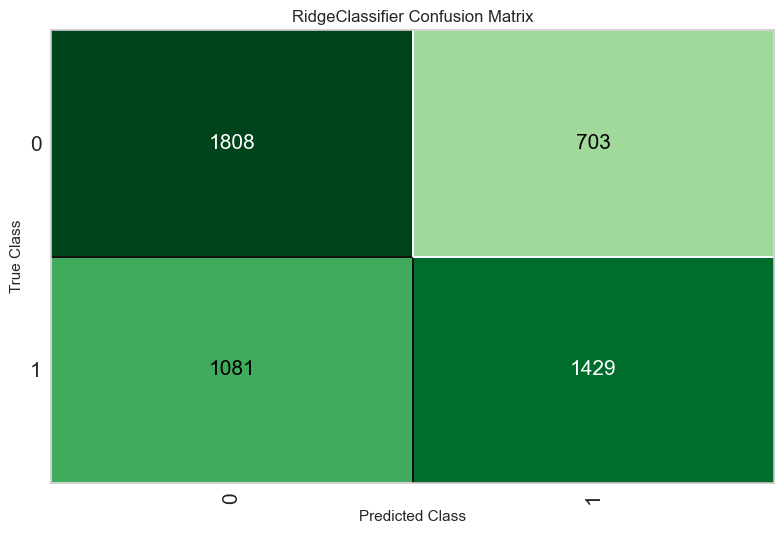

TypeError: AUC plot not available for estimators with no predict_proba attribute.

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# PyCaret 라이브러리 임포트
from pycaret.classification import *

# 데이터 로드
print("데이터 로드 중...")
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

print(f"학습 데이터 크기: {train_df.shape}")
print(f"테스트 데이터 크기: {test_df.shape}")
print(f"제출 샘플 크기: {sample_submission.shape}")

# 기본적인 데이터 정보 확인
print("\n학습 데이터 정보:")
print(train_df.info())

print("\n결측치 확인:")
print(train_df.isnull().sum())

# 타겟 변수 분포 확인
print("\n타겟 변수(Cancer) 분포:")
print(train_df['Cancer'].value_counts())
print(f"암 양성 비율: {train_df['Cancer'].mean() * 100:.2f}%")

# 1. 데이터 전처리
print("\n데이터 전처리 진행 중...")

# ID 열 drop
train_df_processed = train_df.drop('ID', axis=1)
test_df_processed = test_df.drop('ID', axis=1)

# 범주형(문자열) 변수와 수치형 변수 분리
categorical_cols = train_df_processed.select_dtypes(include=['object']).columns
numerical_cols = train_df_processed.select_dtypes(exclude=['object']).columns.drop('Cancer')

print(f"\n범주형 변수: {list(categorical_cols)}")
print(f"수치형 변수: {list(numerical_cols)}")

# 2. 간단한 특성 엔지니어링
print("\n특성 엔지니어링 진행 중...")

# 아이오딘 결핍과 국가 상호작용 특성 생성
train_df_processed['Iodine_Country_Risk'] = ((train_df_processed['Iodine_Deficiency'] == 'Deficient') & 
                                            (train_df_processed['Country'] == 'IND')).astype(int)
test_df_processed['Iodine_Country_Risk'] = ((test_df_processed['Iodine_Deficiency'] == 'Deficient') & 
                                           (test_df_processed['Country'] == 'IND')).astype(int)

# 수치형 변수의 이상치 클리핑
for col in numerical_cols:
    q1 = train_df_processed[col].quantile(0.01)
    q3 = train_df_processed[col].quantile(0.99)
    train_df_processed[col] = train_df_processed[col].clip(q1, q3)
    test_df_processed[col] = test_df_processed[col].clip(q1, q3)

# StandardScaler 적용
print("\nStandardScaler 적용 중...")
scaler = StandardScaler()
train_df_processed[numerical_cols] = scaler.fit_transform(train_df_processed[numerical_cols])
test_df_processed[numerical_cols] = scaler.transform(test_df_processed[numerical_cols])

# 3. 클래스 불균형 처리 (SMOTE 대신 직접 샘플링)
print("\n클래스 균형을 맞추기 위한 샘플링 진행 중...")

# Cancer=0과 Cancer=1 데이터 분리
cancer_positive = train_df_processed[train_df_processed['Cancer'] == 1]
cancer_negative = train_df_processed[train_df_processed['Cancer'] == 0]

# 원하는 비율로 조정 (예: 양성:음성 = 1:1 또는 다른 비율)
# 여기서는 양성 샘플 수를 기준으로 음성 샘플을 동일한 수로 랜덤 샘플링
n_positive = len(cancer_positive)
negative_sampled = cancer_negative.sample(n=n_positive, random_state=42)

# 균형 잡힌 데이터셋 생성
balanced_train_df = pd.concat([cancer_positive, negative_sampled])

# 셔플
balanced_train_df = balanced_train_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"균형 조정 후 학습 데이터 크기: {balanced_train_df.shape}")
print(f"균형 조정 후 Cancer 분포:")
print(balanced_train_df['Cancer'].value_counts())
print(f"균형 조정 후 암 양성 비율: {balanced_train_df['Cancer'].mean() * 100:.2f}%")

# 학습 데이터와 검증 데이터 분리 (20%)
train_data, val_data = train_test_split(balanced_train_df, test_size=0.2, random_state=42, stratify=balanced_train_df['Cancer'])

print(f"학습 데이터 크기: {train_data.shape}")
print(f"검증 데이터 크기: {val_data.shape}")

# 4. PyCaret 설정 및 모델 비교
print("\nPyCaret으로 여러 모델 비교 중...")

# PyCaret 세션 초기화 (fix_imbalance=False로 설정, 이미 직접 균형을 맞췄으므로)
clf = setup(
    data=train_data,  # 균형이 조정된 학습 데이터
    target='Cancer',  # 타겟 변수
    numeric_features=list(numerical_cols) + ['Iodine_Country_Risk'],  # 수치형 변수
    categorical_features=list(categorical_cols),  # 범주형 변수
    ignore_features=['ID'] if 'ID' in train_data.columns else [],  # 무시할 변수
    normalize=False,  # 이미 StandardScaler 적용했으므로 False로 설정
    transformation=True,  # 데이터 변환 수행
    fix_imbalance=False,  # SMOTE 등의 자동 불균형 처리 비활성화
    session_id=42,  # 랜덤 시드
    fold=5,  # 5-폴드 교차 검증
    verbose=True  # 세부 정보 출력
)

# 모든 모델 비교 - 기본 설정으로 모든 모델 학습 및 평가
print("\n모든 모델 학습 및 비교 중...")
best_models = compare_models(
    sort='f1',  # F1 점수 기준으로 정렬
    n_select=3,  # 상위 3개 모델 선택
    verbose=True  # 세부 정보 출력
)

# 여러 개의 모델이 있을 경우 첫 번째(가장 좋은) 모델 선택
if isinstance(best_models, list):
    best_model = best_models[0]
else:
    best_model = best_models

# 최고 모델 이름 출력
print(f"\n최고 성능 모델: {best_model}")

# 모델 분석
print("\n최고 모델 분석 중...")

# 학습된 모델 평가
evaluate_model(best_model)

# 하이퍼파라미터 튜닝
print("\n최고 모델 하이퍼파라미터 튜닝 중...")
tuned_model = tune_model(
    best_model,
    optimize='f1',  # F1 점수 최적화
    n_iter=10,  # 10번의 튜닝 반복
    verbose=True  # 세부 정보 출력
)

# 튜닝된 모델 평가
print("\n튜닝된 모델 평가 중...")
evaluate_model(tuned_model)

# 모델 해석
print("\n모델 해석 중...")
try:
    # 기본 해석 방법 사용 (SHAP 없이)
    interpret_model(tuned_model)
except Exception as e:
    print(f"모델 해석 중 오류 발생: {e}")
    print("모델 해석을 건너뛰고 계속 진행합니다.")

# 최종 모델 학습
print("\n최종 모델 생성 중...")
final_model = finalize_model(tuned_model)

# 최종 모델 저장
print("\n최종 모델 저장 중...")
save_model(final_model, 'final_cancer_model')

# 테스트 데이터에 예측
print("\n테스트 데이터에 예측 중...")
predictions = predict_model(final_model, data=test_df_processed)

# 예측 결과 추출
test_predictions = predictions['prediction_label'].astype(int)

# sample_submission 파일에 예측 결과 저장
sample_submission['Cancer'] = test_predictions
sample_submission.to_csv('balanced_sampling_submission.csv', index=False)

print("\n예측 완료! 'balanced_sampling_submission.csv' 파일에 결과가 저장되었습니다.")

# 예측 결과 확인
print("예측 결과 분포:")
print(sample_submission['Cancer'].value_counts())
print(f"암 양성 예측 비율: {sample_submission['Cancer'].mean() * 100:.2f}%")